# Installing and Importing Required Libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
import random
from PIL import Image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [5]:
dataset_path = "/content/drive/MyDrive/BTP/times_new_roman_dataset_with_precision"
csv_path = "labelsReg.csv"

In [6]:
import pandas as pd
data = pd.read_csv(csv_path)
print(data.head())

                             filename             font           text  \
0  Times_New_Roman_51.73px_508ca9.png  Times New Roman  Sample text 2   
1  Times_New_Roman_49.22px_3d8321.png  Times New Roman  Sample text 1   
2  Times_New_Roman_59.65px_f4487c.png  Times New Roman  Sample text 2   
3  Times_New_Roman_35.52px_ce140e.png  Times New Roman  Sample text 3   
4  Times_New_Roman_17.42px_5aefa6.png  Times New Roman  Sample text 1   

   font_size text_color  
0      51.73      black  
1      49.22      black  
2      59.65      black  
3      35.52      black  
4      17.42      black  


# Data Preprocessing

In [7]:
images = []
font_sizes = []

for index, row in data.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("L")
        img = img.resize((32, 32))
        img = np.array(img) / 255.0

        images.append(img)
        font_sizes.append(row['font_size'])

images = np.array(images).reshape(-1, 32, 32, 1)
font_sizes = np.array(font_sizes)

# **Step 1: Create Binned Categories for Stratification**
num_bins = 5  # Number of bins to stratify
binner = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
font_bins = binner.fit_transform(font_sizes.reshape(-1, 1)).astype(int).flatten()

# **Step 2: Stratified Split Based on Binned Font Sizes**
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(images, font_bins))

x_train, x_test = images[train_idx], images[test_idx]
y_train, y_test = font_sizes[train_idx], font_sizes[test_idx]

# **Step 3: Scale Font Sizes for Regression**
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


# Build CNN Regression Model


In [8]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def create_lenet_regression():
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1), padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (5, 5), activation='relu', padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(120, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.Dense(84, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.Dense(1,
                     kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
    ])

    return model

model = create_lenet_regression()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=['mae'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,941 (238.05 KB)

 Trainable params: 60,941 (238.05 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

loss, mae = model.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.2f} px")

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2541 - mae: 0.3820 - val_loss: 0.0989 - val_mae: 0.2581 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0562 - mae: 0.2033 - val_loss: 0.0722 - val_mae: 0.2232 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0472 - mae: 0.1783 - val_loss: 0.0490 - val_mae: 0.1827 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0295 - mae: 0.1517 - val_loss: 0.0376 - val_mae: 0.1632 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0247 - mae: 0.1310 - val_loss: 0.0278 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0178 - mae: 0.1158 - val_loss: 0.0201 - val_mae: 0.1081 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0133 - mae: 0.0939 - val_loss: 0.0148 - val_mae: 0.0936 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━

In [10]:
y_pred = model.predict(x_test)

y_pred = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_test)

print("Actual vs Predicted Font Sizes:")
for actual, predicted in zip(y_test_original.flatten(), y_pred.flatten()):
    print(f"Actual: {actual:.2f}  |  Predicted: {predicted:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Actual vs Predicted Font Sizes:
Actual: 12.10  |  Predicted: 13.95
Actual: 46.52  |  Predicted: 46.22
Actual: 47.46  |  Predicted: 49.34
Actual: 40.14  |  Predicted: 37.86
Actual: 44.61  |  Predicted: 47.34
Actual: 31.08  |  Predicted: 30.25
Actual: 58.88  |  Predicted: 58.46
Actual: 18.35  |  Predicted: 17.31
Actual: 38.96  |  Predicted: 40.80
Actual: 23.89  |  Predicted: 23.70
Actual: 59.98  |  Predicted: 57.10
Actual: 11.65  |  Predicted: 8.61


# Training History

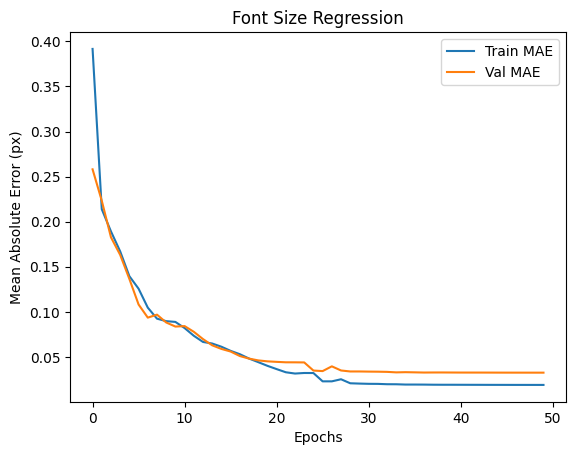

In [11]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (px)')
plt.title('Font Size Regression')
plt.show()
